# Time Series Classification: Intact or Scrambled?

The goal is to predict the trial type (intact or scrambled) based on the raw timeseries data.

## Import modules and set path.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


PATH='/Users/nickhedger/Documents'

## Load in files.

Here I load the timeseries and labels into a pandas dataframe

In [2]:
def load_data(PATH,FILE):
	csvpath=os.path.join(PATH,FILE)
	return pd.read_csv(csvpath)


TIMESERIES=load_data(PATH,'TIMESERIES_CLEAN.csv') # The full timeseries data.
SCRAMLAB=load_data(PATH,'SCLABELS_CLEAN.csv') # The labels corresponding to whether the trial was scrambled or not.

## Review data structure

In [3]:
TIMESERIES.shape

(2811500, 6)

In [4]:
SCRAMLAB.shape

(5623, 2)

The timeseries data has the following structure: There is the id (timeseries number) a timestamp and a corresponding X and Y value for each timestamp. There are 500 X and Y values per timeseries.

In [5]:
TIMESERIES.head()

,Unnamed: 0,id,time,X,Y,ps
0,1,1,1,762.3,639.5,1
1,2,1,2,762.3,639.5,1
2,3,1,3,762.3,639.5,1
3,4,1,4,762.3,639.5,1
4,5,1,5,762.3,639.5,1


There are 5623 timeseries, each of which has a corresponding label in the SCRAMLAB dataframe (1= intact, 2 =scrambled).

In [6]:
len(np.unique(TIMESERIES["id"]))

5623

In [7]:
SCRAMLAB.head()

,Unnamed: 0,sc
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


SCRAMLAB just codes the labels to be classified (1 per timeseries). Plot an example timeseries instance.

In [5]:
# Plot a timeseries and add some bells and whistles. Plot where the stimuli are and a title indicating whether
# it was a scrambled or intact trial.
import matplotlib.patches as patches
SCRAMLAB=SCRAMLAB.drop('Unnamed: 0',1)
def tsplot(FRAME,id):
    fig1, ax =plt.subplots(1)
    instance=FRAME[(FRAME["id"]==id)]
    plt.plot(instance['X'],instance['Y'])
    plt.axis([100,1500,300,900])
    rect=patches.Rectangle((168,378),544,444,facecolor='none',edgecolor='r') # Plot the stimulus area
    rect2=patches.Rectangle((888,378),544,444,facecolor='none',edgecolor='r')
    ax.add_patch(rect)
    ax.add_patch(rect2)
    num=SCRAMLAB.iloc[id-1,0] # Reference the timeseries with the label. 
    lab="Scram = %d" % (num)
    plt.title(lab)
    plt.show()

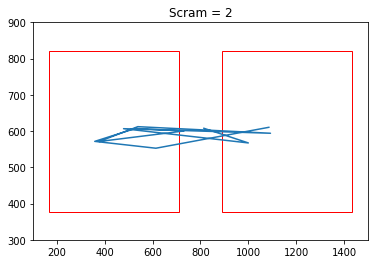

In [6]:
x=tsplot(TIMESERIES,141) # Plot the coordinates of a timeseries.


In [7]:
# Drop columns not required.
TIMESERIES=TIMESERIES.drop('Unnamed: 0',1)
TIMESERIES=TIMESERIES.drop('ps',1)

## Classifcation of intact versus scrambled images

Now we get the labels into a 1D format.

In [8]:
# Re-structure labels into a 1D numpy array
LABELS=SCRAMLAB
LABELSPREP=pd.DataFrame.as_matrix(LABELS)
LABELSPREP=np.squeeze(LABELSPREP)

In [9]:
LABELSPREP.shape

(5623,)

Now the data are all in the correct format, import the tsfresh module and ask it to engineer some features. The  [following features are calculated](http://tsfresh.readthedocs.io/en/latest/text/list_of_features.html). This takes hours....

In [10]:
#import tsfresh
from tsfresh import extract_relevant_features

/Users/nickhedger/anaconda2/envs/i2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [11]:
features_filtered_direct = extract_relevant_features(TIMESERIES, LABELSPREP,
                                                     column_id='id', column_sort='time')

Feature Extraction: 10it [3:31:44, 1270.45s/it]                        
 'X__friedrich_coefficients__m_3__r_30__coeff_1'
 'X__friedrich_coefficients__m_3__r_30__coeff_2'
 'X__friedrich_coefficients__m_3__r_30__coeff_3'
 'X__max_langevin_fixed_point__m_3__r_30'
 'Y__friedrich_coefficients__m_3__r_30__coeff_0'
 'Y__friedrich_coefficients__m_3__r_30__coeff_1'
 'Y__friedrich_coefficients__m_3__r_30__coeff_2'
 'Y__friedrich_coefficients__m_3__r_30__coeff_3'
 'Y__max_langevin_fixed_point__m_3__r_30'] did not have any finite values. Filling with zeros.


In this next section I dumped the data into a pickle (commented out). Here I can also load the pickle object.   

In [5]:
# Dump the data. 
#import dill                            
#filename = 'T_S_dump_clean2.pkl'
#dill.dump_session(os.path.join(PATH,filename))
# Load the data
import dill
import os
#PATH='/Users/nickhedger/Documents'
#dill.load_session(os.path.join(PATH,'T_S_dump_clean2.pkl'))


/Users/nickhedger/anaconda2/envs/env/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Inspect the structure of the extracted features. It's in a pandas dataframe format.

In [7]:
features_filtered_direct.head()

variable,X__number_cwt_peaks__n_1,Y__number_cwt_peaks__n_1,X__ratio_value_number_to_time_series_length,Y__ratio_value_number_to_time_series_length,X__sample_entropy,Y__approximate_entropy__m_2__r_0.1,Y__sum_of_reoccurring_values,Y__approximate_entropy__m_2__r_0.3,X__variance,X__standard_deviation,...,"X__fft_coefficient__coeff_15__attr_""angle""","Y__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""slope""","X__fft_coefficient__coeff_29__attr_""abs""","X__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""slope""","Y__fft_coefficient__coeff_14__attr_""imag""","X__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""","X__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_5","X__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_10__w_5","Y__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.0",X__first_location_of_maximum
id,,,,,,,,,,,,,,,,,,,,,
1,10.0,10.0,0.020,0.020,1.361701,0.069963,6583.2,0.061495,82805.549340,287.759534,...,-164.719693,0.809137,2005.857266,92.702781,874.070800,490.265455,899.722765,399.512752,0.194457,0.794
2,13.0,13.0,0.026,0.024,1.279313,0.094173,7825.1,0.100075,116950.871890,341.980806,...,117.296457,1.323983,2467.114832,8.337922,1404.309742,449.643636,800.926727,440.852329,0.079756,0.616
3,9.0,9.0,0.018,0.018,0.949978,0.082168,5026.7,0.077263,122986.538696,350.694367,...,-4.868142,-0.480166,2212.195163,103.638843,-1364.857258,659.701818,925.522500,531.856550,-0.119874,0.732
4,14.0,13.0,0.030,0.030,1.231056,0.114255,9163.8,0.105340,74225.197703,272.443017,...,47.587397,-0.513948,948.394477,-41.818858,-65.821355,1055.840000,904.443861,401.609106,0.010162,0.672
5,13.0,13.0,0.026,0.026,1.129762,0.098275,8287.7,0.077954,87283.405329,295.437650,...,-117.782013,0.031152,1681.207984,-22.308434,149.625866,626.796364,949.131739,634.313919,0.104282,0.442


Order the features by their relevance and show the 10 most relevant

In [8]:
#from tsfresh.feature_selection.relevance import calculate_relevance_table
templab=pd.Series(LABELSPREP,index=np.unique(TIMESERIES["id"]))
templab.head()
templab.unique
from tsfresh.feature_selection.relevance import calculate_relevance_table
sigtable=calculate_relevance_table(X=features_filtered_direct,y=templab)

In [9]:
sigtable.head(n=10)

,feature,type,p_value,relevant
feature,,,,
X__number_cwt_peaks__n_1,X__number_cwt_peaks__n_1,real,5.514309e-81,True
Y__number_cwt_peaks__n_1,Y__number_cwt_peaks__n_1,real,1.640190e-80,True
X__ratio_value_number_to_time_series_length,X__ratio_value_number_to_time_series_length,real,5.024521e-78,True
Y__ratio_value_number_to_time_series_length,Y__ratio_value_number_to_time_series_length,real,7.938752e-78,True
X__sample_entropy,X__sample_entropy,real,7.812907e-73,True
Y__approximate_entropy__m_2__r_0.1,Y__approximate_entropy__m_2__r_0.1,real,9.035624e-72,True
Y__sum_of_reoccurring_values,Y__sum_of_reoccurring_values,real,2.044030e-71,True
Y__approximate_entropy__m_2__r_0.3,Y__approximate_entropy__m_2__r_0.3,real,4.364815e-62,True
X__variance,X__variance,real,1.208259e-58,True


Its hard to get a grasp of what these features actually are without visualising some trials. Define a function for showing the k trials that represent the highest and lowest of a feature.

In [10]:
def SHOWFEATURE(feature):
    reldim=feature[0]
    fig, ax = plt.subplots(figsize=(20, 20))
    for i in range(4): # Plot the top 4 instances
        for j in range(4):
            ax = plt.subplot2grid((4,4), (i,j))
            if j==0: 
                league=features_filtered_direct.sort_values(by=[feature],ascending=True) # The lowest values
                idt=league.iloc[[i]].index[0] # Get the id
                var=round(league[feature].iloc[i],3) # Get the value of the variable
                instance=TIMESERIES[(TIMESERIES["id"]==idt)] # Get the timeseries corresponding to the ID
                plt.axis([100,1500,300,900])
                rect=patches.Rectangle((168,378),544,444,facecolor='none',edgecolor='r') # Plot the grid area
                rect2=patches.Rectangle((888,378),544,444,facecolor='none',edgecolor='r')
                num=SCRAMLAB.iloc[idt-1,0] # Reference the timeseries with the label to determine whether it was scrambled or not
                ax.add_patch(rect)
                ax.add_patch(rect2)
                lab="ID= %d, var= %f Scram = %d" % (idt,var,num)
                ax.set_title(lab)
                ax.plot(instance['X'],instance['Y'])
            elif j==1:
                league=features_filtered_direct.sort_values(by=[feature],ascending=False) # The highest values
                idt=league.iloc[[i]].index[0] # Get the id
                var=round(league[feature].iloc[i],3) # Get the value of the variable
                instance=TIMESERIES[(TIMESERIES["id"]==idt)] # Get the timeseries corresponding to the ID
                plt.axis([100,1500,300,900])
                rect=patches.Rectangle((168,378),544,444,facecolor='none',edgecolor='r') # Plot the grid area
                rect2=patches.Rectangle((888,378),544,444,facecolor='none',edgecolor='r')
                num=SCRAMLAB.iloc[idt-1,0] # Reference the timeseries with the label to determine whether it was scrambled or not
                ax.add_patch(rect)
                ax.add_patch(rect2)
                lab="ID= %d, var= %f Scram = %d" % (idt,var,num)
                ax.set_title(lab)
                ax.plot(instance['X'],instance['Y'])
            elif j==2:
                league=features_filtered_direct.sort_values(by=[feature],ascending=True) # The highest values
                idt=league.iloc[[i]].index[0] # Get the id
                var=round(league[feature].iloc[i],3) # Get the value of the variable
                instance=TIMESERIES[(TIMESERIES["id"]==idt)] # Get the timeseries corresponding to the ID
                num=SCRAMLAB.iloc[idt-1,0] # Reference the timeseries with the label to determine whether it was scrambled or not
                lab="ID= %d, var= %f Scram = %d" % (idt,var,num)
                ax.set_title(lab)
                ax.plot(instance[reldim])
                ax.set_ylim(TIMESERIES[reldim].min(), TIMESERIES[reldim].max())
            elif j==3:
                league=features_filtered_direct.sort_values(by=[feature],ascending=False) # The highest values
                idt=league.iloc[[i]].index[0] # Get the id
                var=round(league[feature].iloc[i],3) # Get the value of the variable
                instance=TIMESERIES[(TIMESERIES["id"]==idt)] # Get the timeseries corresponding to the ID
                num=SCRAMLAB.iloc[idt-1,0] # Reference the timeseries with the label to determine whether it was scrambled or not
                lab="ID= %d, var= %f Scram = %d" % (idt,var,num)
                ax.set_title(lab)
                ax.plot(instance[reldim])
                ax.set_ylim(TIMESERIES[reldim].min(), TIMESERIES[reldim].max())

Now plot the 4 trials that represent the lowest (left) and highest (right) of the most informative feature. Plot the eye movement trace, but also the timeseries of the relevant dimension (X or Y).

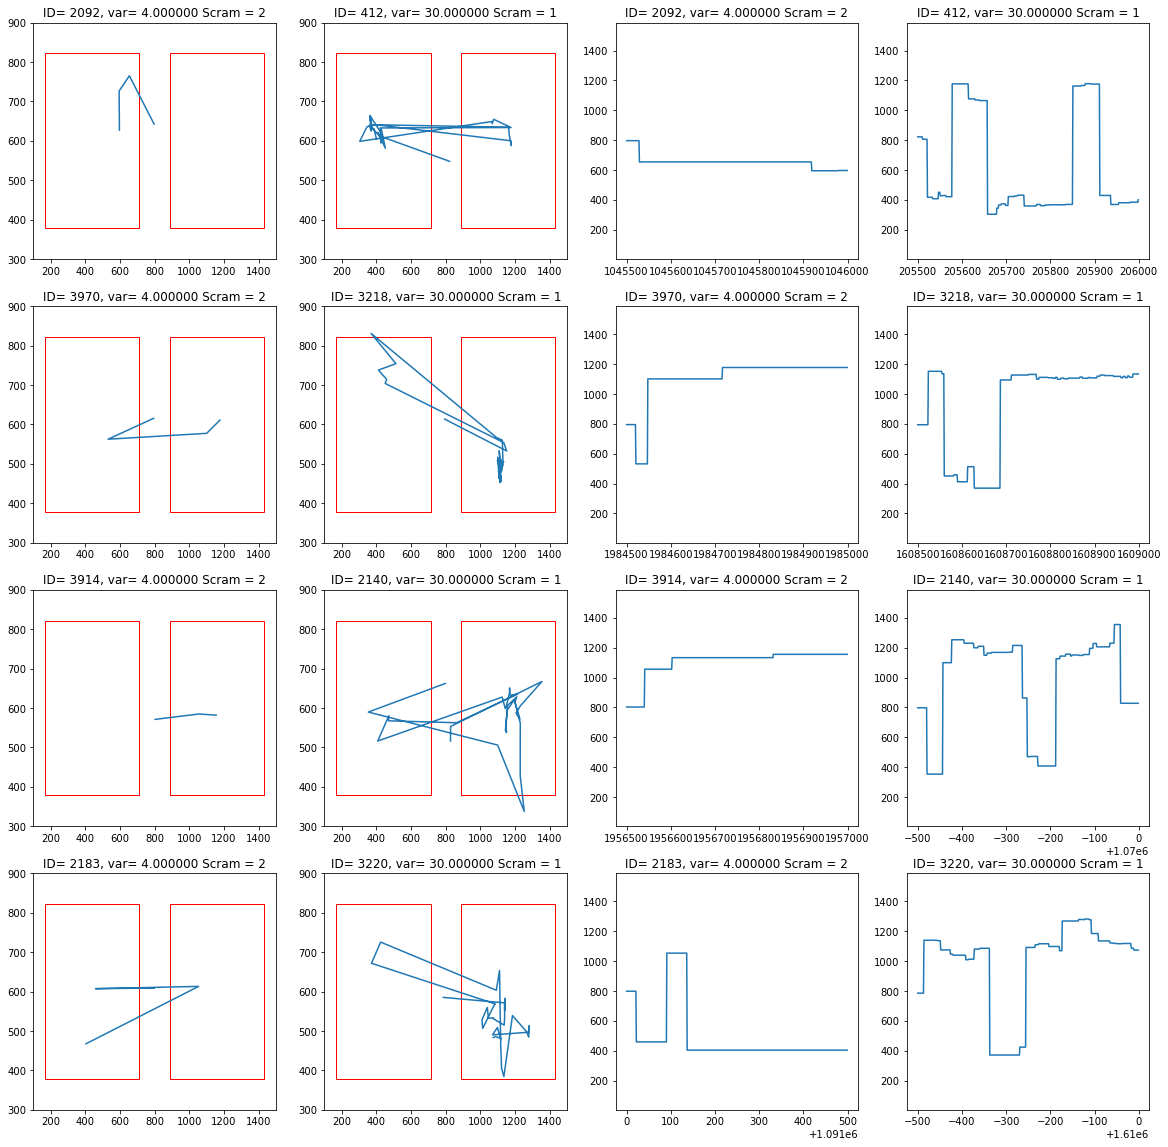

In [11]:
SHOWFEATURE('X__number_cwt_peaks__n_1')

This seems to show that intact trials have more variation in the X dimension. Now standardise the feature matrix

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
trans=scaler.fit(features_filtered_direct)
scaled=scaler.transform(features_filtered_direct)

Split the data into a training (80%) and test (20%) set.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(scaled, LABELSPREP, test_size=.2)


Fit a random forest classifier to the training data.

In [14]:
from sklearn.ensemble import RandomForestClassifier
cl = RandomForestClassifier() 
cl.fit(X_train, y_train) # Fit to the training data

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Get the accuracy score for the training data.

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, cl.predict(X_train))

0.98666073810582477

Now perform cross-validation (10 folds)

In [16]:
scoreCV=cross_val_score(cl,X_train,y_train,cv=10,scoring='accuracy') # Cross validate.

scoreCV

array([ 0.70444444,  0.71111111,  0.67111111,  0.66888889,  0.68888889,
        0.70888889,  0.66888889,  0.69777778,  0.69333333,  0.69866071])

The model seems to be over-fitting. Also check the classification performance for the test data

In [17]:
from sklearn.metrics import classification_report # Show performance at classifying the test data
print(classification_report(y_test, cl.predict(X_test)))

             precision    recall  f1-score   support

          1       0.68      0.76      0.72       567
          2       0.72      0.63      0.67       558

avg / total       0.70      0.70      0.69      1125



Take a look at the features that ended up being the most important for the random forest classifier

In [18]:
attributes=list(features_filtered_direct)

sorted(zip(cl.feature_importances_,attributes),reverse=True)


[(0.025434940346791463, 'X__sample_entropy'),
 (0.017206678300126337,
  'X__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_3__w_20'),
 (0.013721339815520917,
  'X__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_1__w_20'),
 (0.012578705664410958,
  'X__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_20'),
 (0.012041108136161837,
  'X__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_4__w_20'),
 (0.011856152747798927,
  'X__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_6__w_20'),
 (0.010920489654867149,
  'X__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_3__w_10'),
 (0.0092015670527031898, 'Y__sum_of_reoccurring_values'),
 (0.0082627463399971048, 'X__number_cwt_peaks__n_5'),
 (0.0080594990394581931, 'X__approximate_entropy__m_2__r_0.5'),
 (0.0075144753580226624, 'X__number_cwt_peaks__n_1'),
 (0.007253604650832998,
  'X__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_10__w_10'),
 (0.0061596113735000639, 'Y__approximate_entropy__m_2__r_0.5'),
 (0.0060238791731034285,
  'X__cwt_coeffici

Plot some of the most important features and how they vary across conditions.

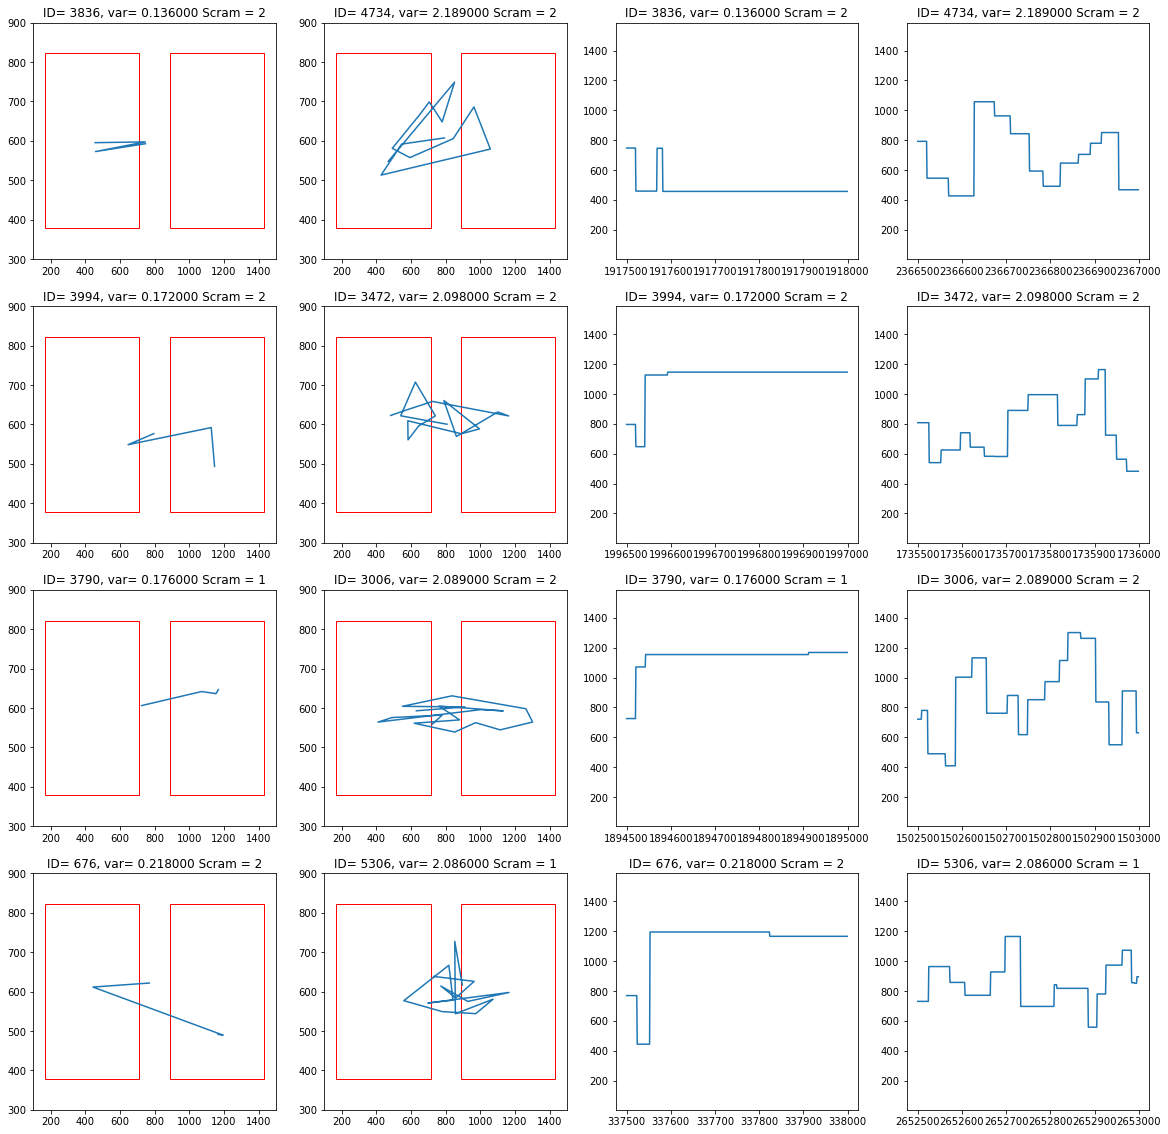

In [19]:
def featureplot(FRAME,LABELS,FEATURE):
    feature=np.column_stack((np.array(FRAME[FEATURE]),np.squeeze(np.array(pd.DataFrame(LABELS)))))
    intact=feature[np.where(feature[:,-1] == 1)]
    scrambled=feature[np.where(feature[:,-1] == 2)]
    plt.subplot(1, 2, 1)
    plt.boxplot(intact[:,0])
    plt.title('Intact')
    ax1=plt.gca()
    ax1.set_ylim(ymin=feature[:,-2].min(), ymax=feature[:,-2].max())
    plt.subplot(1, 2, 2)
    plt.boxplot(scrambled[:,0])
    plt.title('Scrambled')
    ax2=plt.gca()
    ax2.set_ylim(ymin=feature[:,-2].min(), ymax=feature[:,-2].max())

SHOWFEATURE('X__sample_entropy')

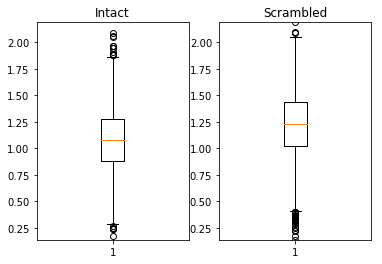

In [20]:
featureplot(features_filtered_direct,LABELS,'X__sample_entropy')

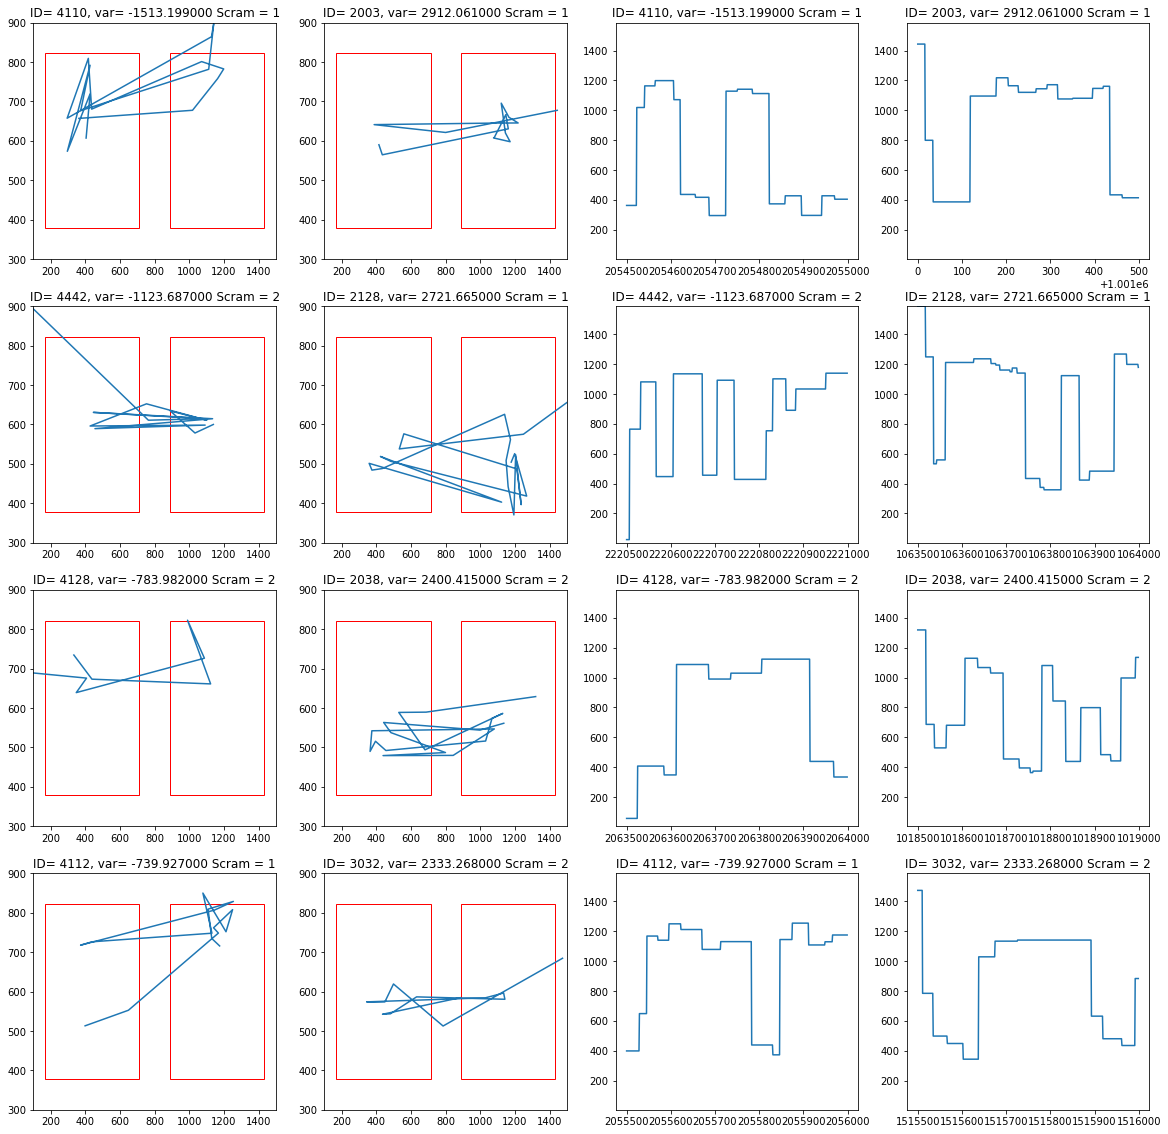

In [21]:
SHOWFEATURE('X__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_3__w_20')

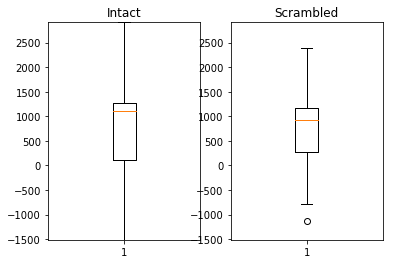

In [22]:
featureplot(features_filtered_direct,LABELS,'X__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_3__w_20')

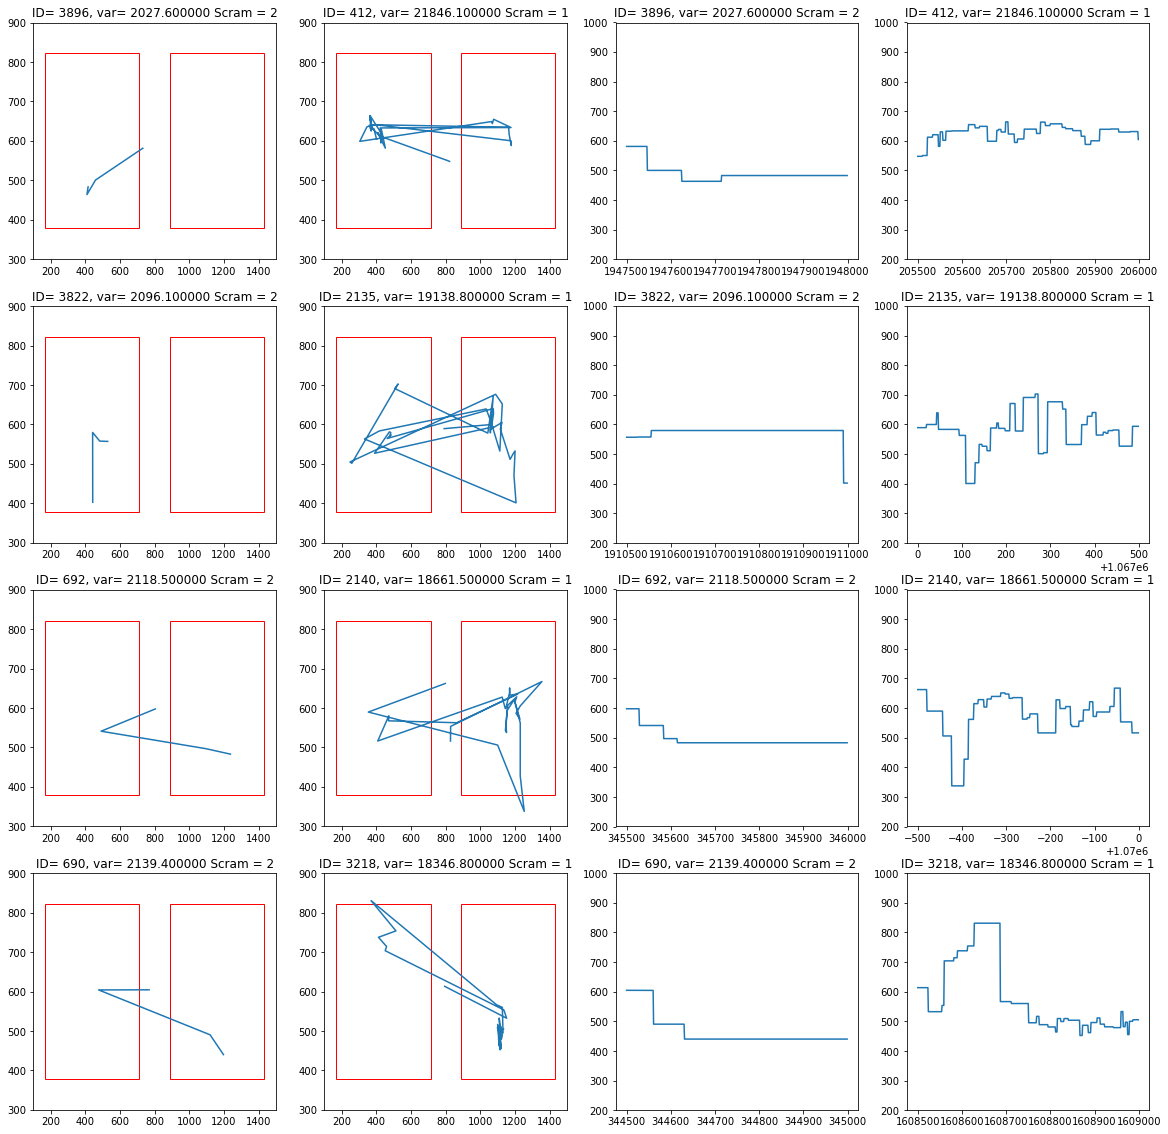

In [23]:
SHOWFEATURE('Y__sum_of_reoccurring_values')

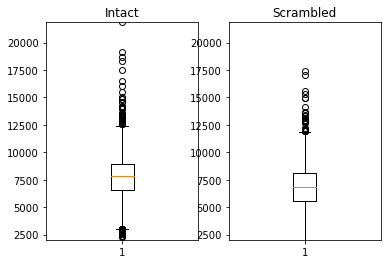

In [24]:
featureplot(features_filtered_direct,LABELS,'Y__sum_of_reoccurring_values')

Since we were over-fitting, create a new feature matrix using the top k features.

In [25]:
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])


top_k=indices_of_top_k(cl.feature_importances_,20)

toplabels=np.array(attributes)[top_k]

topkmat=np.array(scaled)[:,top_k]


X_train, X_test, y_train, y_test = train_test_split(topkmat, LABELSPREP, test_size=.2)

from sklearn.ensemble import RandomForestClassifier

cl2 = RandomForestClassifier()
cl2.fit(X_train, y_train)

scoreCV2=cross_val_score(cl2,X_train,y_train,cv=10,scoring='accuracy')


In [26]:
scoreCV2

array([ 0.73392461,  0.72505543,  0.71840355,  0.68070953,  0.71046771,
        0.70378619,  0.73273942,  0.74832962,  0.71046771,  0.71046771])

Perform a grid search of hyper-parameters. (Takes a few minutes).

In [27]:
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 15, 30], 'max_features': [5, 10, 20],'max_depth': [10,15,20],'min_samples_leaf': [15,20,30],'warm_start':[True,False]}]


from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(cl2, param_grid, cv=5,scoring='accuracy')

grid_search.fit(X_train, y_train)


cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)


(0.710760337927968, {'max_features': 5, 'n_estimators': 3, 'warm_start': True, 'max_depth': 10, 'min_samples_leaf': 15})
(0.7169853268119164, {'max_features': 5, 'n_estimators': 3, 'warm_start': False, 'max_depth': 10, 'min_samples_leaf': 15})
(0.73743886171631834, {'max_features': 5, 'n_estimators': 10, 'warm_start': True, 'max_depth': 10, 'min_samples_leaf': 15})
(0.73766118274788794, {'max_features': 5, 'n_estimators': 10, 'warm_start': False, 'max_depth': 10, 'min_samples_leaf': 15})
(0.73654957759004003, {'max_features': 5, 'n_estimators': 15, 'warm_start': True, 'max_depth': 10, 'min_samples_leaf': 15})
(0.73677189862160963, {'max_features': 5, 'n_estimators': 15, 'warm_start': False, 'max_depth': 10, 'min_samples_leaf': 15})
(0.74032903512672299, {'max_features': 5, 'n_estimators': 30, 'warm_start': True, 'max_depth': 10, 'min_samples_leaf': 15})
(0.73610493552690082, {'max_features': 5, 'n_estimators': 30, 'warm_start': False, 'max_depth': 10, 'min_samples_leaf': 15})
(0.715651

In [ ]:
grid_search.best_estimator_

In [28]:
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

             precision    recall  f1-score   support

          1       0.75      0.77      0.76       592
          2       0.73      0.72      0.72       533

avg / total       0.74      0.74      0.74      1125



Looks like we can get to 74% classification of the test data based on 20 features of the timeseries.

Now plot the feature matrices for the intact and scrambled data.

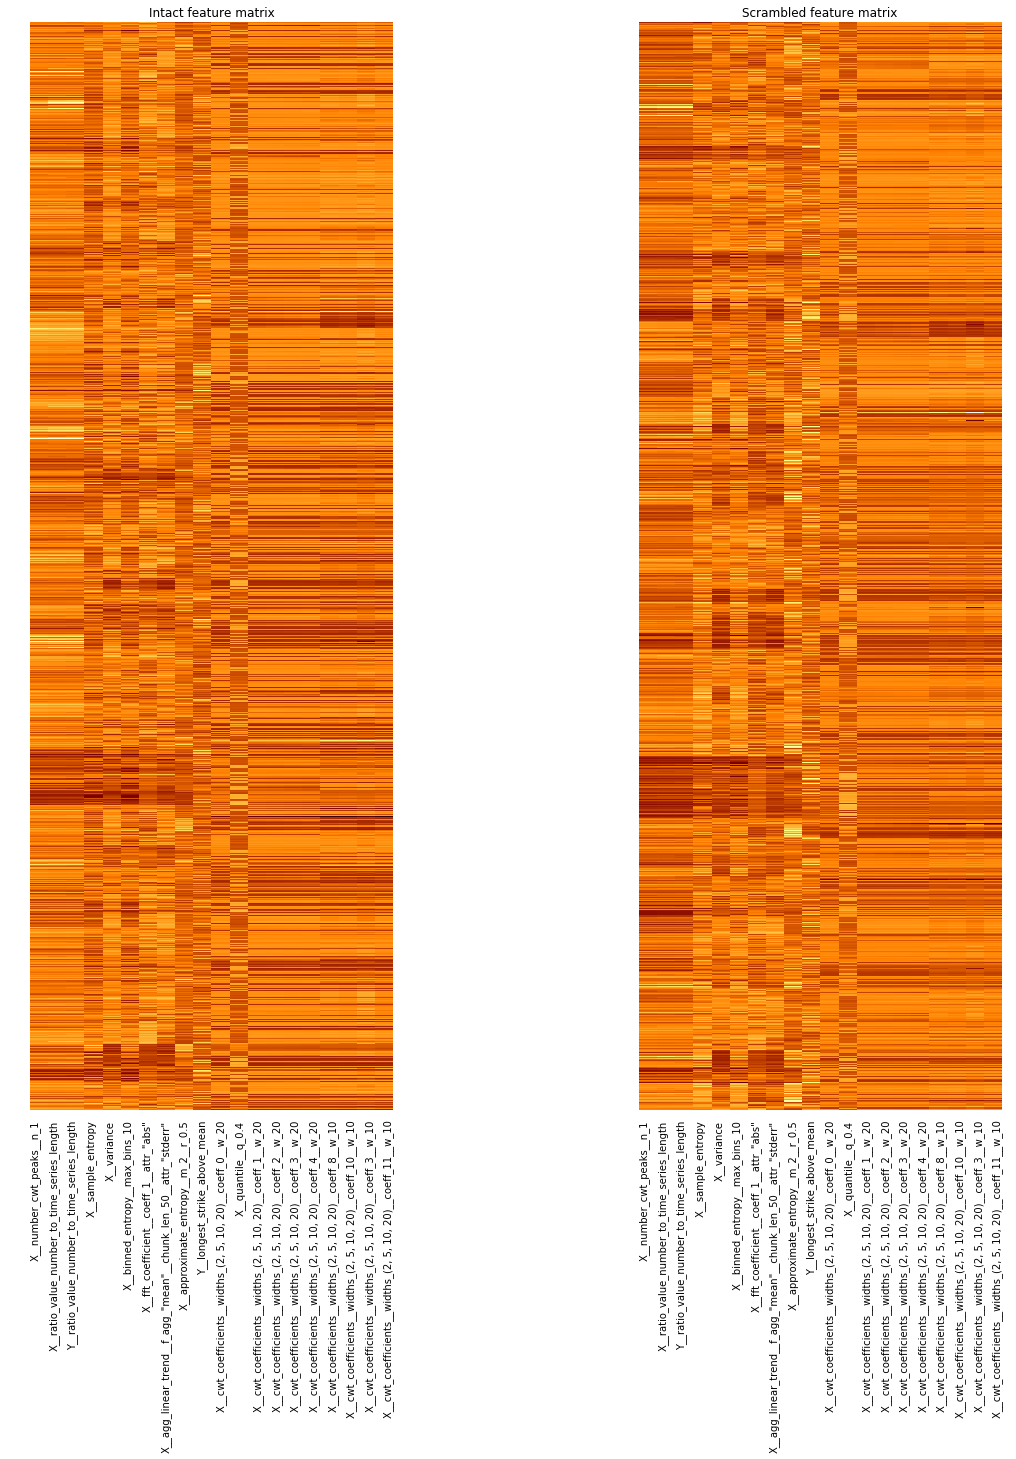

In [41]:
scaledwithlabs=np.concatenate((topkmat,np.array(pd.DataFrame(LABELS))),axis=1)
scaledint=scaledwithlabs[np.where(scaledwithlabs[:,-1] == 1)]
scaledsc=scaledwithlabs[np.where(scaledwithlabs[:,-1] == 2)]
from matplotlib import cm, colors
fig, ax = plt.subplots(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(scaledint[:,0:-1],cmap='afmhot',vmin=topkmat.min(), vmax=topkmat.max(),extent=[0, 1, 0, 3])
plt.title("Intact feature matrix")
coords=np.linspace(start=0, stop=0.975, num=topkmat.shape[1])
for i in range(topkmat.shape[1]):
    plt.text(coords[i],-0.05,toplabels[i],rotation=90)
plt.axis('off')
plt.grid(which='minor', axis='y', linewidth=10)
plt.subplot(1, 2, 2)
plt.imshow(scaledsc[:,0:-1],cmap='afmhot',vmin=topkmat.min(), vmax=topkmat.max(),extent=[0, 1, 0, 3])
plt.title("Scrambled feature matrix")
plt.axis('off')
for i in range(topkmat.shape[1]):
    plt.text(coords[i],-0.05,toplabels[i],rotation=90)
    